# Extract and Format ERA5

Extract a target region from ERA5 files and process to long format

In [360]:
import pygrib
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd

In [361]:
import os
try:
    os.environ['PROJ_LIB'] = '/home/robwall/anaconda2/envs/metocean_data_py3/share/proj'
    from mpl_toolkits.basemap import Basemap
except:
    os.environ['PROJ_LIB'] = '/home/robwall/anaconda3/envs/py27/share/proj'
    from mpl_toolkits.basemap import Basemap


### Extraction region

In [362]:
lat_range = [-31, -25]
lon_range = [152, 157]

# Create extended range
extended_lat_range = np.array(lat_range)
extended_lat_range[0] += -2 
extended_lat_range[1] += 2

extended_lon_range = np.array(lon_range)
extended_lon_range[0] += -2 
extended_lon_range[1] += 2



## Load some data

In [363]:
grb_f = "../data/era5_201707.grib"
sample_grb_f = "../data/era5_20180601.grib"
ww3_f = "../data/nww3.t00z.grib.grib2.grb"

In [364]:
era = pygrib.open(grb_f)

In [365]:
sample_era = pygrib.open(sample_grb_f)

In [366]:
ww3 = pygrib.open(ww3_f)

## View Region

In [367]:
def plot_aus_waves(grb_f=None, grbs=None, ww3_f=None, grbs_ww3=None):
    if grbs == None:
        grbs = pygrib.open(grb_f)
    grb = grbs.select(name="Significant height of combined wind waves and swell")[0]
    data = grb.values
    lat, lon = grb.latlons()
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    m=Basemap(projection="mill", lat_ts=10, llcrnrlon=140,
         urcrnrlon=165, llcrnrlat=-36, urcrnrlat=-10,
         resolution='c', ax=ax)
    x, y = m(lon, lat)
    cs = m.pcolormesh(x,y,data,shading='flat',cmap=plt.cm.jet)
    m.drawcoastlines()
    m.fillcontinents()
    m.drawmapboundary()
    m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

    # Plot model points
    ax.scatter(x, y, alpha=0.8, s=1, color='k')
        
    # Plot region
    box_lon = [lon_range[0], lon_range[0],
              lon_range[1], lon_range[1],
              lon_range[0]]
    box_lat = [lat_range[0], lat_range[1],
              lat_range[1], lat_range[0],
              lat_range[0]]
    x_box, y_box = m(box_lon, box_lat)
    ax.plot(x_box, y_box, color="green")
    
    # Load ww3
    if grbs_ww3 is None:
        grbs_ww3 = pygrib.open(ww3_f)
    grbs_ww3 = grbs_ww3.select(name="Significant height of combined wind waves and swell")[0]
    ww3lat, ww3lon= grbs_ww3.latlons()
    xww3, yww3 = m(ww3lon, ww3lat)
    ax.scatter(xww3, yww3, s=30, color = "red", marker="x", alpha=0.5)
    
    plt.title(grb_f)
    plt.show()

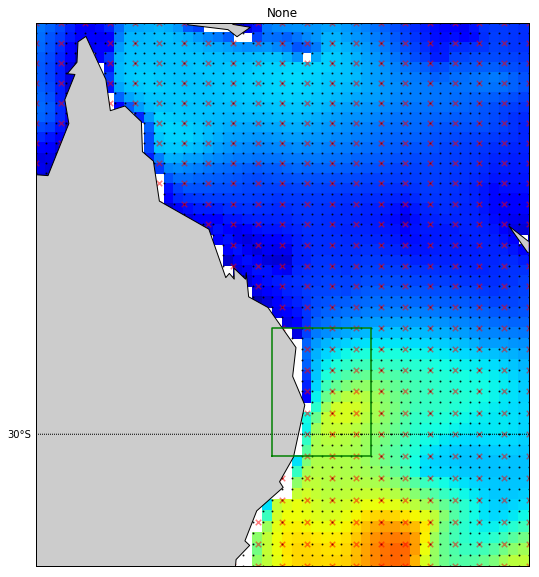

In [368]:
plot_aus_waves(grbs=sample_era, grbs_ww3=ww3)

Identify variables

In [369]:
era_vars_short = set([v.shortName for v in sample_era.select()])
era_vars = set([v.name for v in sample_era.select()])

In [370]:
era_vars

{u'10 metre U wind component',
 u'10 metre V wind component',
 u'Mean direction of total swell',
 u'Mean direction of wind waves',
 u'Mean period of total swell',
 u'Mean period of wind waves',
 u'Mean wave direction',
 u'Mean wave direction of first swell partition',
 u'Mean wave direction of second swell partition',
 u'Mean wave period',
 u'Mean wave period based on first moment for swell',
 u'Mean wave period of first swell partition',
 u'Mean wave period of second swell partition',
 u'Significant height of combined wind waves and swell',
 u'Significant height of wind waves'}

In [371]:
era_vars_short

{u'10u',
 u'10v',
 u'mdts',
 u'mdww',
 u'mpts',
 u'mpww',
 u'mwd',
 u'mwd1',
 u'mwd2',
 u'mwp',
 u'mwp1',
 u'mwp2',
 u'p1ps',
 u'shww',
 u'swh'}

In [372]:
sample_grb = sample_era.select(name="Significant height of combined wind waves and swell")
sample_ww3 = ww3.select(name="Significant height of combined wind waves and swell")

In [373]:
sample_grb[0].analDate

datetime.datetime(2018, 6, 1, 0, 0)

Get data and lat, lons within target region

In [374]:
sample_data_region = sample_grb[0].data(lat1=extended_lat_range[0], lat2=extended_lat_range[1],
                                        lon1=extended_lon_range[0], lon2=extended_lon_range[1])
sample_ww3_region = sample_ww3[0].data(lat1=extended_lat_range[0], lat2=extended_lat_range[1],
                                        lon1=extended_lon_range[0], lon2=extended_lon_range[1])

In [375]:
lat, lon = sample_grb[0].latlons()
ww3_lat, ww3_lon = sample_ww3[0].latlons()

### Data extraction

Process:

- Extract data within region
- Interpolate to GFS grid
- Convert to long format

#### 1. Extract region

In [376]:
def slice_latlon(lat, lon, lat_range, lon_range):
    mask = (lat >= lat_range[0]) & (lat <= lat_range[1]) & \
           (lon >= lon_range[0]) & (lon <= lon_range[1])
    
    dim1 = np.any(mask, axis=1).sum()
    dim2 = np.any(mask, axis=0).sum()
    
    lat_extract = lat[mask].reshape(dim1, dim2)
    lon_extract = lon[mask].reshape(dim1, dim2)
    
    return lat_extract, lon_extract

In [377]:
lat_extract, lon_extract = slice_latlon(lat, lon, lat_range, lon_range)
target_lat, target_lon = slice_latlon(ww3_lat, ww3_lon, lat_range, lon_range)

extended_lat_extract, extended_lon_extract = slice_latlon(lat, lon, extended_lat_range, extended_lon_range)
extended_target_lat, extended_target_lon = slice_latlon(ww3_lat, ww3_lon, extended_lat_range, extended_lon_range)

In [378]:
def plot_extract(data, lat, lon, ww3lat, ww3lon, fig=None, ax=None):
    
    if (ax is None) and (fig is None):
        fig, ax = plt.subplots(figsize=(10,10))
    
    m=Basemap(projection="mill", lat_ts=10, llcrnrlon=140,
         urcrnrlon=165, llcrnrlat=-36, urcrnrlat=-10,
         resolution='c', ax=ax)
    x, y = m(lon, lat)
    cs = m.pcolormesh(x,y,data,shading='flat',cmap=plt.cm.jet)
    m.drawcoastlines()
    m.fillcontinents()
    m.drawmapboundary()
    m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

    # Plot model points
    ax.scatter(x, y, alpha=0.8, s=1, color='k')
        
    # Plot region
    box_lon = [lon_range[0], lon_range[0],
              lon_range[1], lon_range[1],
              lon_range[0]]
    box_lat = [lat_range[0], lat_range[1],
              lat_range[1], lat_range[0],
              lat_range[0]]
    x_box, y_box = m(box_lon, box_lat)
    ax.plot(x_box, y_box, color="green")
    
    xww3, yww3 = m(ww3lon, ww3lat)
    ax.scatter(xww3, yww3, s=30, color = "black", marker="x", alpha=0.5)
    
    plt.title(grb_f)
    
    return fig, ax
    

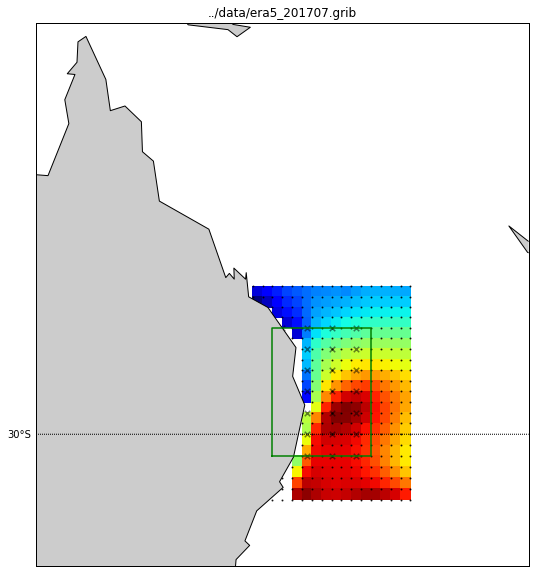

In [379]:
fig, ax = plot_extract(sample_data_region[0], extended_lat_extract, extended_lon_extract, target_lat, target_lon)

In [380]:
target_lat.shape

(7, 4)

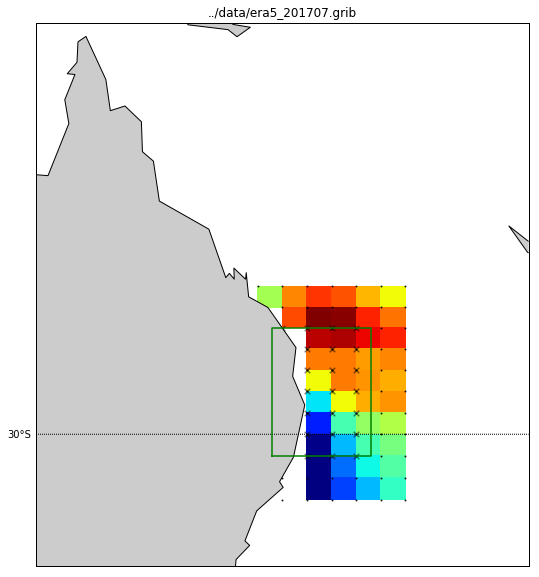

In [381]:
fig, ax = plot_extract(sample_ww3_region[0], extended_target_lat, extended_target_lon, target_lat, target_lon)

#### 2. Interpolate to WW3 grid

In [382]:
def interp_ww3(variable_data, lon, lat, target_lon, target_lat, method='linear'):
    in_values = variable_data[~variable_data.mask].data
    in_lon = lon[~variable_data.mask].flatten()
    in_lat = lat[~variable_data.mask].flatten()
    in_points = np.zeros(shape=(len(in_lon), 2))
    in_points[:,0] = in_lon
    in_points[:,1] = in_lat
    
    interp_data = interpolate.griddata(in_points, in_values, (target_lon, target_lat), method=method)
    
    return interp_data

In [383]:
interp_cubic = interp_ww3(sample_data_region[0], extended_lon_extract, extended_lat_extract, target_lon, target_lat, 'cubic')
interp_linear = interp_ww3(sample_data_region[0], extended_lon_extract, extended_lat_extract, target_lon, target_lat, 'linear')
interp_nearest = interp_ww3(sample_data_region[0], extended_lon_extract, extended_lat_extract, target_lon, target_lat, 'nearest')

sample_data_narrow = sample_grb[0].data(lat1=lat_range[0], lat2=lat_range[1],
                                        lon1=lon_range[0], lon2=lon_range[1])
interp_non_extended_cubic = interp_ww3(sample_data_narrow[0], lon_extract, lat_extract, target_lon, target_lat, 'cubic')
interp_non_extended_linear = interp_ww3(sample_data_narrow[0], lon_extract, lat_extract, target_lon, target_lat, 'linear')
interp_non_extended_nearest = interp_ww3(sample_data_narrow[0], lon_extract, lat_extract, target_lon, target_lat, 'nearest')

Text(0.5,1,'NN (non-extended)')

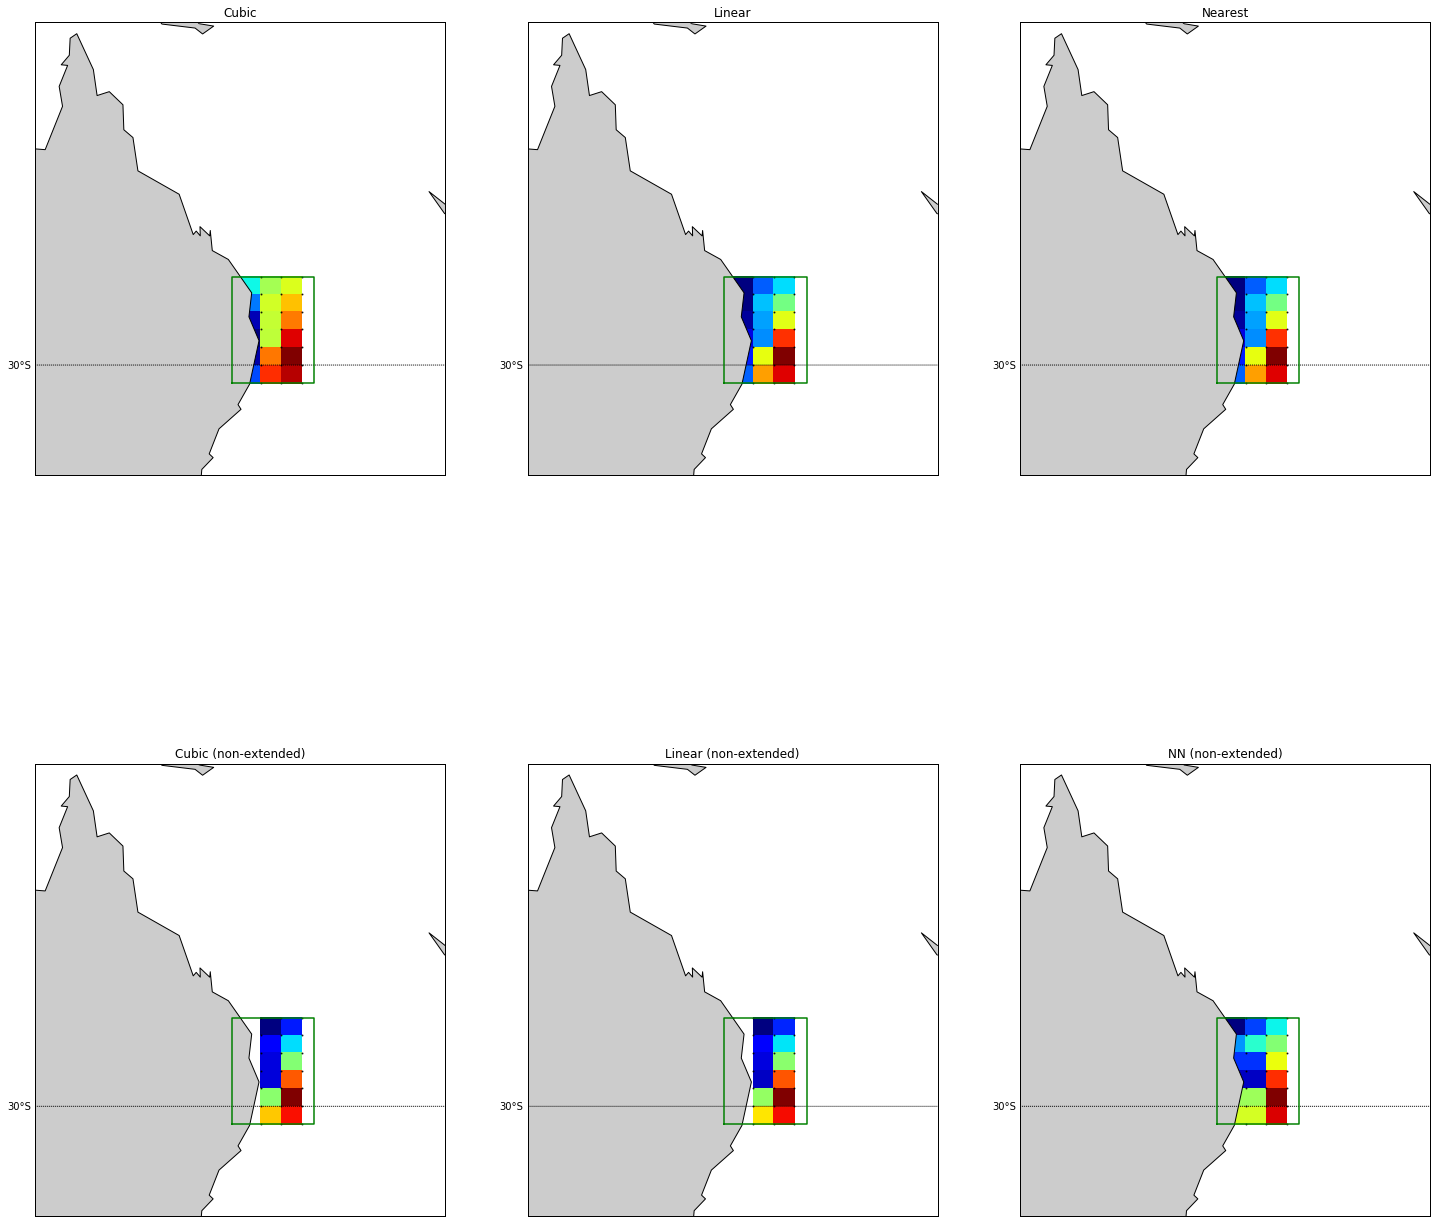

In [384]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,25))

# Cubic
_, _ = plot_extract(interp_cubic, target_lat, target_lon, [0], [0], ax=ax[0,0])
ax[0,0].set_title("Cubic")

# Linear
_, _ = plot_extract(interp_linear, target_lat, target_lon, [0], [0], ax=ax[0,1])
ax[0,1].set_title("Linear")

# Nearest
_, _ = plot_extract(interp_linear, target_lat, target_lon, [0], [0], ax=ax[0,2])
ax[0,2].set_title("Nearest")

# Non-extended cubic
_, _ = plot_extract(interp_non_extended_cubic, target_lat, target_lon, [0], [0], ax=ax[1,0])
ax[1,0].set_title("Cubic (non-extended)")

# Non-extended linear
_, _ = plot_extract(interp_non_extended_linear, target_lat, target_lon, [0], [0], ax=ax[1,1])
ax[1,1].set_title("Linear (non-extended)")

# Non-extended nearest
_, _ = plot_extract(interp_non_extended_nearest, target_lat, target_lon, [0], [0], ax=ax[1,2])
ax[1,2].set_title("NN (non-extended)")

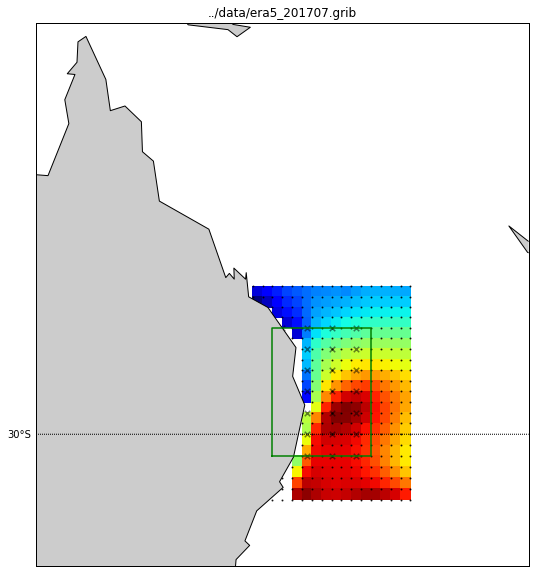

In [385]:
fig, ax = plot_extract(sample_data_region[0], extended_lat_extract, extended_lon_extract, target_lat, target_lon)

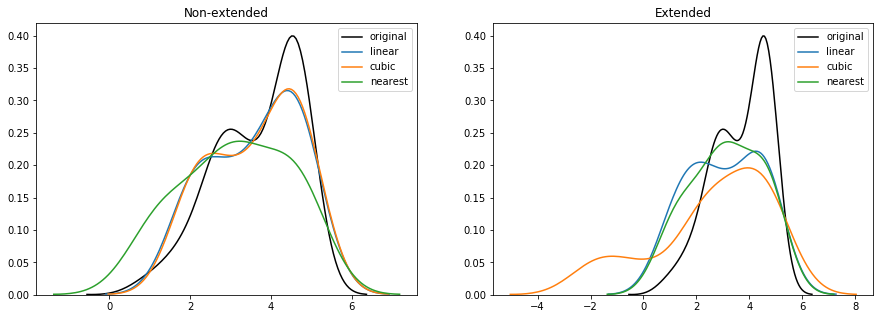

In [386]:
fig ,ax = plt.subplots(ncols=2, figsize=(15,5))

ax[0].set_title("Non-extended")
sns.distplot(in_values, ax=ax[0], label="original", color="k",
             hist=False)
sns.distplot(interp_non_extended_linear[~np.isnan(interp_non_extended_linear)], ax=ax[0], label="linear",
             hist=False)
sns.distplot(interp_non_extended_cubic[~np.isnan(interp_non_extended_cubic)], ax=ax[0], label="cubic",
             hist=False)
sns.distplot(interp_non_extended_nearest[~np.isnan(interp_non_extended_nearest)], ax=ax[0], label="nearest",
             hist=False)

ax[1].set_title("Extended")
sns.distplot(in_values, ax=ax[1], label="original", color="k",
             hist=False)
sns.distplot(interp_linear[~np.isnan(interp_linear)], ax=ax[1], label="linear",
             hist=False)
sns.distplot(interp_cubic[~np.isnan(interp_cubic)], ax=ax[1], label="cubic",
             hist=False)
sns.distplot(interp_nearest[~np.isnan(interp_nearest)], ax=ax[1], label="nearest",
             hist=False)
plt.show()

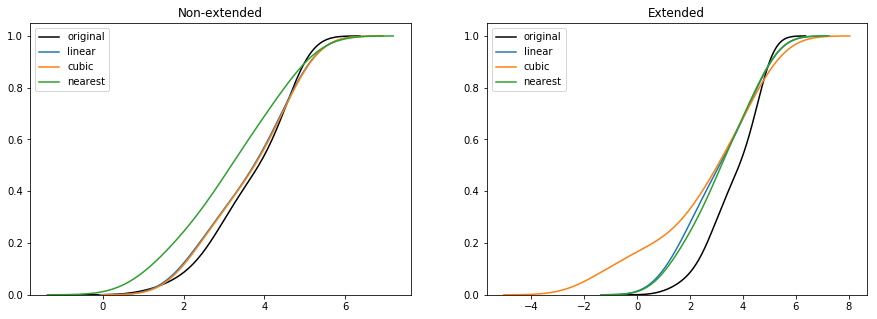

In [387]:
fig ,ax = plt.subplots(ncols=2, figsize=(15,5))

ax[0].set_title("Non-extended")
sns.distplot(in_values, ax=ax[0], label="original", color="k",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_non_extended_linear[~np.isnan(interp_non_extended_linear)], ax=ax[0], label="linear",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_non_extended_cubic[~np.isnan(interp_non_extended_cubic)], ax=ax[0], label="cubic",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_non_extended_nearest[~np.isnan(interp_non_extended_nearest)], ax=ax[0], label="nearest",
             hist=False, kde_kws=dict(cumulative=True))

ax[1].set_title("Extended")
sns.distplot(in_values, ax=ax[1], label="original", color="k",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_linear[~np.isnan(interp_linear)], ax=ax[1], label="linear",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_cubic[~np.isnan(interp_cubic)], ax=ax[1], label="cubic",
             hist=False, kde_kws=dict(cumulative=True))
sns.distplot(interp_nearest[~np.isnan(interp_nearest)], ax=ax[1], label="nearest",
             hist=False, kde_kws=dict(cumulative=True))
plt.show()

Non-extended cubic or linear seem to be the best downsizing options

#### 3. Convert to long format

In [388]:
sample_ww3_region_non_extended = sample_ww3[0].data(lat1=lat_range[0], lat2=lat_range[1],
                                        lon1=lon_range[0], lon2=lon_range[1])

In [389]:
sample_ww3_region_non_extended[0].data

array([[9.999e+03, 2.650e+00, 2.660e+00, 2.600e+00],
       [9.999e+03, 2.450e+00, 2.450e+00, 2.410e+00],
       [9.999e+03, 2.290e+00, 2.450e+00, 2.420e+00],
       [9.999e+03, 1.950e+00, 2.290e+00, 2.390e+00],
       [9.999e+03, 1.720e+00, 2.050e+00, 2.160e+00],
       [9.999e+03, 1.550e+00, 1.900e+00, 2.050e+00],
       [9.999e+03, 1.540e+00, 1.810e+00, 1.970e+00]])

In [390]:
def interp_to_long(interp_data, mask, var_name, dt):
    interp_data = interp_data[~mask]
    col_names = var_col_names(len(interp_data), var_name)
    #df = pd.DataFrame(data = interp_data, columns=col_names, index=dt)
    df = pd.DataFrame(columns=col_names)
    df.loc[0] = interp_data
    df.index = [dt]
    
    return df
    

In [391]:
def var_col_names(n, var_name):
    return ["{}_p{}".format(var_name, i) for i in range(1, n+1)]

In [392]:
str_lat_lon(5, sample_grb[0].shortName)

['swh_p1', 'swh_p2', 'swh_p3', 'swh_p4', 'swh_p5']

In [393]:
df = interp_to_long(interp_non_extended_linear, sample_ww3_region_non_extended[0].mask,
                    sample_grb[0].shortName, sample_grb[0].analDate)
df.head()

,swh_p1,swh_p2,swh_p3,swh_p4,swh_p5,swh_p6,swh_p7,swh_p8,swh_p9,swh_p10,...,swh_p12,swh_p13,swh_p14,swh_p15,swh_p16,swh_p17,swh_p18,swh_p19,swh_p20,swh_p21
2018-06-01,1.802291,2.322188,2.526534,2.205733,2.941573,3.157637,2.070113,3.478438,3.840499,2.001876,...,4.7238,3.522261,5.044844,4.817183,3.963301,4.703292,4.503707,4.403121,4.626876,4.500167


## Inspect non-masked data

Not all data (i.e. wind) uses a mask

In [442]:
era_var_grids = []
for var in set([v.name for v in sample_era]):
    temp_grb = sample_era.select(name=var)
    temp_lat, _ = temp_grb[0].latlons()
    temp_lat_shape = temp_lat.shape
    array_type = type(temp_grb[0].data()[0])
    era_var_grids.append((var, temp_lat_shape, array_type))
sample_era.seek(0)

In [443]:
era_var_grids

[(u'Significant height of combined wind waves and swell',
  (361, 720),
  numpy.ma.core.MaskedArray),
 (u'Mean wave direction of second swell partition',
  (361, 720),
  numpy.ma.core.MaskedArray),
 (u'Mean wave period', (361, 720), numpy.ma.core.MaskedArray),
 (u'Mean wave period of first swell partition',
  (361, 720),
  numpy.ma.core.MaskedArray),
 (u'10 metre V wind component', (721, 1440), numpy.ndarray),
 (u'Significant height of wind waves', (361, 720), numpy.ma.core.MaskedArray),
 (u'Mean wave direction of first swell partition',
  (361, 720),
  numpy.ma.core.MaskedArray),
 (u'Mean direction of wind waves', (361, 720), numpy.ma.core.MaskedArray),
 (u'Mean period of wind waves', (361, 720), numpy.ma.core.MaskedArray),
 (u'Mean direction of total swell', (361, 720), numpy.ma.core.MaskedArray),
 (u'Mean wave period based on first moment for swell',
  (361, 720),
  numpy.ma.core.MaskedArray),
 (u'Mean wave direction', (361, 720), numpy.ma.core.MaskedArray),
 (u'Mean wave period of 

In [444]:
ww3_var_grids = []
for var in set([v.name for v in ww3]):
    temp_grb = ww3.select(name=var)
    temp_lat, _ = temp_grb[0].latlons()
    temp_lat_shape = temp_lat.shape
    array_type = type(temp_grb[0].data()[0])
    ww3_var_grids.append((var, temp_lat_shape, array_type))
ww3.seek(0)

In [445]:
ww3_var_grids

[(u'Significant height of combined wind waves and swell',
  (157, 288),
  numpy.ma.core.MaskedArray),
 (u'Primary wave mean period', (157, 288), numpy.ma.core.MaskedArray),
 (u'Primary wave direction', (157, 288), numpy.ma.core.MaskedArray),
 (u'Wind speed', (157, 288), numpy.ma.core.MaskedArray),
 (u'Significant height of wind waves', (157, 288), numpy.ma.core.MaskedArray),
 (u'Wind direction', (157, 288), numpy.ma.core.MaskedArray),
 (u'U component of wind', (157, 288), numpy.ma.core.MaskedArray),
 (u'Direction of wind waves', (157, 288), numpy.ma.core.MaskedArray),
 (u'Mean period of wind waves', (157, 288), numpy.ma.core.MaskedArray),
 (u'V component of wind', (157, 288), numpy.ma.core.MaskedArray),
 (u'Secondary wave direction', (157, 288), numpy.ma.core.MaskedArray),
 (u'Secondary wave mean period', (157, 288), numpy.ma.core.MaskedArray)]

All variables in ww3 use masks, and all but the `u` and `v` wind components in ERA5 use masks. Also, the wind components use a higher grid resolution than the rest of the variables